In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six.moves import xrange
from sklearn.cluster import DBSCAN

In [2]:
eye_size = 100
smile_size = 300
head_size = 1000
noise = 0.1

In [3]:
# generate left eye
x_c = -1.0
y_c = 1.0
l_eye = np.add(np.random.normal(loc = 0.0, scale=noise, size=(eye_size,2)),[x_c, y_c])
l_label = np.full(shape = eye_size, fill_value=0, dtype=int)
plt.scatter(l_eye[:,0],l_eye[:,1], color = "brown")

In [4]:
# generate right eye
x_c = 1.0
y_c = 1.0
r_eye = np.add(np.random.normal(loc = 0.0, scale=noise, size=(eye_size,2)),[x_c, y_c])
r_label = np.full(shape = eye_size, fill_value=1, dtype=int)
plt.scatter(r_eye[:,0],r_eye[:,1], color = "blue")

In [5]:
# generate smile, params are radius and theta
r_c = 1.5
th_c_min = -0.8
th_c_max = -th_c_min
th_smile = np.random.random(smile_size)*(th_c_max-th_c_min)+th_c_min
r_smile = np.random.normal(loc = r_c, scale = noise, size = smile_size)
x_smile = np.sin(th_smile) * r_smile
y_smile = -np.cos(th_smile) * r_smile
smile = np.dstack((x_smile, y_smile))[0]
s_label = np.full(shape = smile_size, fill_value=2, dtype=int)
plt.scatter(smile[:,0],smile[:,1], color = "indigo")

In [6]:
# generate head
r_c = 3
th_c_min = -np.pi
th_c_max = -th_c_min
th_head = np.random.random(head_size)*(th_c_max-th_c_min)+th_c_min
r_head = np.random.normal(loc = r_c, scale = noise, size = head_size)
x_head = np.sin(th_head) * r_head
y_head = np.cos(th_head) * r_head
head = np.dstack((x_head, y_head))[0]
h_label = np.full(shape = head_size, fill_value=3, dtype=int)
plt.scatter(head[:,0],head[:,1], color = "green")

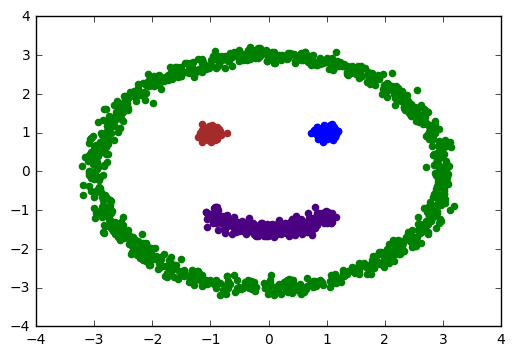

In [7]:
values = np.concatenate((l_eye, r_eye, smile, head))
labels = np.concatenate((l_label,r_label, s_label, h_label))
plt.show()

In [8]:
db = DBSCAN(eps=0.2, min_samples=10).fit(values)

Estimated number of clusters: 4


/home/aluo/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


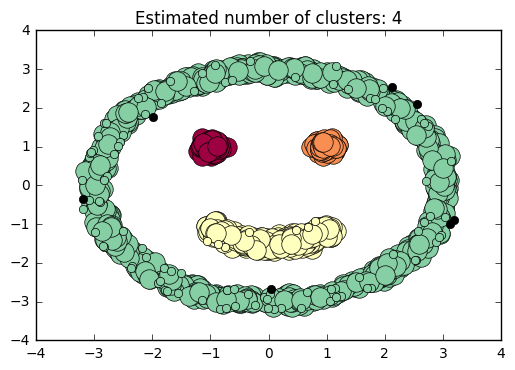

In [9]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_dbscan = db.labels_
n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print('Estimated number of clusters: %d' % n_clusters_)
unique_labels = set(labels_dbscan)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    class_member_mask = (labels_dbscan == k)
    xy = values[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    xy = values[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

('DecisionTreehas a score of', 1.0)
('RandomForest with 100 estimatorshas a score of', 1.0)


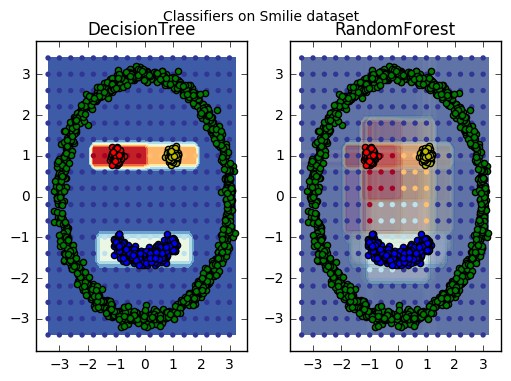

In [10]:
models = [DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100)]
plot_step = 0.2
plot_step_coarser = 0.4
plot_idx = 1
plot_colors = "rybg"
cmap = plt.cm.RdYlBu
n_classes = 4
for model in models:
    clf = clone(model)
    clf = model.fit(values, labels)
    scores = clf.score(values, labels)
    model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
    model_details = model_title
    if hasattr(model, "estimators_"):
        model_details += " with {} estimators".format(len(model.estimators_))
    print(model_details + "has a score of", scores)
    plt.subplot(1, 2, plot_idx)
    plt.subplot(1, 2, plot_idx)
    if plot_idx <= len(models):
        # Add a title at the top of each column
        plt.title(model_title)
    # Now plot the decision boundary using a fine mesh as input to a
    # filled contour plot
    x_min, x_max = values[:, 0].min()-0.2, values[:, 0].max() + 0.2
    y_min, y_max = values[:, 1].min() - 0.2, values[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    if isinstance(model, DecisionTreeClassifier):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, cmap=cmap)
    else:
        estimator_alpha = 1.0 / len(model.estimators_)
        for tree in model.estimators_:
            Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)
    # Build a coarser grid to plot a set of ensemble classifications
    # to show how these are different to what we see in the decision
    # surfaces. These points are regularly space and do not have a black outline
    xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                         np.arange(y_min, y_max, plot_step_coarser))
    Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
    cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")
    # Plot the training points, these are clustered together and have a
    # black outline
    for i, c in zip(xrange(n_classes), plot_colors):
        idx = np.where(labels == i)
        plt.scatter(values[idx, 0], values[idx, 1], c=c, label=labels[i],
                    cmap=cmap)
    plot_idx += 1  # move on to the next plot in sequence
plt.suptitle("Classifiers on Smilie dataset")
plt.axis("tight")
plt.show()

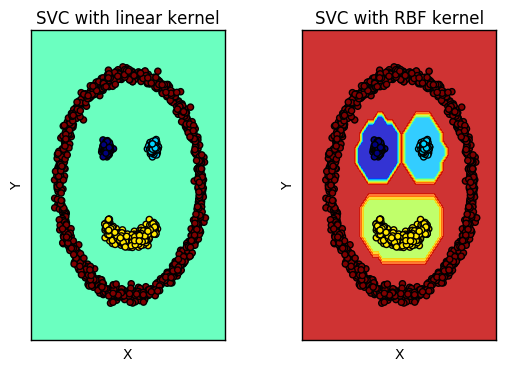

In [11]:
from sklearn import svm
h = .2  # step size in the mesh
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(values, labels)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.9, C=C).fit(values, labels)
# create a mesh to plot in
x_min, x_max = values[:, 0].min() - 1, values[:, 0].max() + 1
y_min, y_max = values[:, 1].min() - 1, values[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel']
for i, clf in enumerate((svc, rbf_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.jet, alpha=0.8)
    # Plot also the training points
    plt.scatter(values[:, 0], values[:, 1], c=labels, cmap=plt.cm.jet)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
plt.show()